In [1]:
using Pkg
#Pkg.add(url="https://github.com/jakubMitura14/MedPipe3D.jl.git")
Pkg.add(url="https://github.com/jakubMitura14/MedPipe3D.jl.git")
import BSON,MedPipe3D
using BSON: @save
using BSON: @load
using MedEye3d
using Distributions
using Clustering
using IrrationalConstants
using ParallelStencil
using MedPipe3D.LoadFromMonai, MedPipe3D.HDF5saveUtils,MedPipe3D.visualizationFromHdf5, MedPipe3D.distinctColorsSaved
using CUDA
using HDF5,Colors
using ParallelStencil
using ParallelStencil.FiniteDifferences3D
using MedEval3D
using MedEval3D.BasicStructs
using MedEval3D.MainAbstractions
using MedEval3D
using MedEval3D.BasicStructs
using MedEval3D.MainAbstractions
using UNet
using Hyperopt,Plots
using MedPipe3D.LoadFromMonai
using Flux,FastAI,DataAugmentation,DLPipelines,MLDataPattern,ImageCore
using DataAugmentation: OneHot, Image
#]add ProgressMeter StaticArrays DataLoaders MLDataPattern BSON DataAugmentation MLUtils Distributed FastAI Flux Hyperopt Plots UNet MedEye3d Distributions Clustering IrrationalConstants ParallelStencil CUDA HDF5 MedEval3D MedPipe3D Colors
CUDA.allowscalar(true)

    Updating git-repo `https://github.com/jakubMitura14/MedPipe3D.jl.git`


    Updating 

registry at `~/.julia/registries/General`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


Some usefull constants

In [2]:

#directory where we want to store our HDF5 that we will use
pathToHDF5="/media/jakub/NewVolume/projects/smallDataSet.hdf5"
# data downloaded from http://medicaldecathlon.com/   (task 9 spleen)
#directory of folder with files in this directory all of the image files should be in subfolder volumes 0-49 and labels labels if one ill use lines below
data_dir = "/media/jakub/NewVolume/forJuliaData/spleenData/Task09_Spleen/Task09_Spleen/Task09_Spleen/"
fid = h5open(pathToHDF5, "w")
#representing number that is the patient id in this dataset
patentNum = 12#6
patienGroupName=string(patentNum)
z=8# how big is the area from which we collect data to construct probability distributions
klusterNumb = 5# number of clusters - number of probability distributions we will use
#******************for display
#just needed so we will not have 2 same colors for two diffrent informations
listOfColorUsed= falses(18)
const USE_GPU = true


true

Below we define path to the example files

In [3]:
data_dir = "/media/jakub/NewVolume/forJuliaData/spleenData/Task09_Spleen/Task09_Spleen/Task09_Spleen/"

train_labels = map(fileEntry-> joinpath(data_dir,"labelsTr",fileEntry),readdir(joinpath(data_dir,"labelsTr"); sort=true))
train_images = map(fileEntry-> joinpath(data_dir,"imagesTr",fileEntry),readdir(joinpath(data_dir,"imagesTr"); sort=true))
#zipping so we will have tuples with image and label names
zipped= collect(zip(train_images,train_labels))
# the paths are for some reasons reading incorrectly
zipped=map(tupl -> (replace(tupl[1], "._" => ""), replace(tupl[2], "._" => "")),zipped)

tupl=zipped[patentNum]
#proper loading using some utility function
targetSpacing=(1,1,1)

loaded = LoadFromMonai.loadBySitkromImageAndLabelPaths(tupl[1],tupl[2],targetSpacing)
# loaded = LoadFromMonai.LoadFromMonai.loadandPad(
#     tupl[1],tupl[2]
#     ,targetSpacing
#     ,(800,800,800))

(Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

...

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0], UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00 … 0x00 0x0

In [4]:
size(loaded[1])

(496, 496, 222)

Managing HDF5 database

In [5]:
#!!!!!!!!!! important if you are just creating the hdf5 file  do it with "w" option otherwise do it with "r+"
#fid = h5open(pathToHDF5, "r+") 
gr= getGroupOrCreate(fid, patienGroupName)

labelArr=map(entry-> UInt32(entry),loaded[2])
#we save loaded and trnsformed data into HDF5 to avoid doing preprocessing every time
saveMaskBeforeVisualization(fid,patienGroupName,loaded[1],"image", "CT" )
saveMaskBeforeVisualization(fid,patienGroupName,labelArr,"labelSet", "boolLabel" )

# here we did default transformations so voxel dimension is set to 1,1,1 in any other case one need to set spacing attribute manually to proper value
# spacing can be found in metadata dictionary that is third entry in loadByMonaiFromImageAndLabelPaths output
# here metadata = loaded[3]
writeGroupAttribute(fid,patienGroupName, "spacing", [1,1,1])

Simple Display Configuration automatically we choose the colors to be some contrassting ones

In [6]:

##below we define additional arrays that are not present in original data but will be needed for annotations and storing algorithm output 

#manual Modification array
manualModif = MedEye3d.ForDisplayStructs.TextureSpec{UInt32}(# choosing number type manually to reduce memory usage
    name = "manualModif",
    color = getSomeColor(listOfColorUsed)# automatically choosing some contrasting color
    ,minAndMaxValue= UInt32.([0,1]) #important to keep the same number type as chosen at the bagining
    ,isEditable = true ) # we will be able to manually modify this array in a viewer

algoVisualization = MedEye3d.ForDisplayStructs.TextureSpec{Float32}(
    name = "algoOutput",
    # we point out that we will supply multiple colors
    isContinuusMask=true,
    colorSet = [getSomeColor(listOfColorUsed),getSomeColor(listOfColorUsed)]
    ,minAndMaxValue= Float32.([0,1])# values between 0 and 1 as this represent probabilities
   )

    addTextSpecs=Vector{MedEye3d.ForDisplayStructs.TextureSpec}(undef,2)
    addTextSpecs[1]=manualModif
    addTextSpecs[2]=algoVisualization



MedEye3d.ForDisplayStructs.TextureSpec{Float32}
  name: String "algoOutput"
  numb: Int32 -1
  whichCreated: Int32 -1
  isMainImage: Bool false
  isNuclearMask: Bool false
  isContinuusMask: Bool true
  color: RGB{Float64}
  colorSet: Array{RGB}((2,))
  strokeWidth: Int32 3
  isEditable: Bool false
  GL_Rtype: UInt32 0x00000000
  OpGlType: UInt32 0x00000000
  actTextrureNumb: UInt32 0x00000000
  associatedActiveNumer: Int64 0
  ID: Base.RefValue{UInt32}
  isVisible: Bool true
  uniforms: MedEye3d.ForDisplayStructs.MaskTextureUniforms
  minAndMaxValue: Array{Float32}((2,)) Float32[0.0, 1.0]
  maskContribution: Float32 1.0f0


Command to Display

In [7]:
mainScrollDat= loadFromHdf5Prim(fid,patienGroupName,addTextSpecs,listOfColorUsed)


increase number of available threads look into https://docs.julialang.org/en/v1/manual/multi-threading/  or modify for example in vs code extension


Dict{Symbol, Any}(

:gl_version => v"4.6.0", :gl_renderer => "NVIDIA GeForce RTX 3080/PCIe/SSE2", :glsl_version => v"4.60.0", :gl_vendor => "NVIDIA Corporation")
Dict{Symbol, Any}(:gl_version => v"4.6.0", :gl_renderer => "NVIDIA GeForce RTX 3080/PCIe/SSE2", :glsl_version => v"4.60.0", :gl_vendor => "NVIDIA Corporation")


MedEye3d.DataStructs.FullScrollableDat
  dataToScrollDims: MedEye3d.DataStructs.DataToScrollDims
  dimensionToScroll: Int64 3
  dataToScroll: Array{MedEye3d.DataStructs.ThreeDimRawDat}((4,))
  mainTextToDisp: Array{MedEye3d.DataStructs.SimpleLineTextStruct}((1,))
  sliceTextToDisp: Array{Vector{MedEye3d.DataStructs.SimpleLineTextStruct}}((222,))
  segmMetr: MedEye3d.BasicStructs.ResultMetrics
  segmMetrs: Array{MedEye3d.BasicStructs.ResultMetrics}((0,))
  nameIndexes: Dictionaries.Dictionary{String, Int64}
  slicesNumber: Int32 222


Here we will modify primary display  by changing the color of displayed label

In [15]:
#manual Modification array
manualModif = MedEye3d.ForDisplayStructs.TextureSpec{UInt32}(# choosing number type manually to reduce memory usage
    name = "manualModif",
    color = RGB(0.2,0.5,0.2) #getSomeColor(listOfColorUsed)# automatically choosing some contrasting color
    ,minAndMaxValue= UInt32.([0,1]) #important to keep the same number type as chosen at the bagining
    ,isEditable = true ) # we will be able to manually modify this array in a viewer

labelSet = MedEye3d.ForDisplayStructs.TextureSpec{UInt32}(
    name = "labelSet",
    # we point out that we will supply multiple colors
    isContinuusMask=true,
    colorSet = [RGB(1.0,0.0,0.0),RGB(1.0,0.0,0.0),RGB(1.0,1.0,0.0)]
    ,minAndMaxValue= UInt32.([0,2])# values between 0 and 1 as this represent probabilities
   )   
    addTextSpecs=Vector{MedEye3d.ForDisplayStructs.TextureSpec}(undef,3)
    addTextSpecs[1]=manualModif
    addTextSpecs[2]=algoVisualization
    addTextSpecs[3]=labelSet


#2) primary display of chosen image 
mainScrollDat= loadFromHdf5Prim(fid,patienGroupName,addTextSpecs,listOfColorUsed)
mainScrollDat.dataToScroll


increase number of available threads look into https://docs.julialang.org/en/v1/manual/multi-threading/  or modify for example in vs code extension


Dict{Symbol, Any}(:gl_version => v"4.6.0", :gl_renderer => "NVIDIA GeForce RTX 3080/PCIe/SSE2", :glsl_version => v"4.60.0", :gl_vendor => "NVIDIA Corporation")
Dict{Symbol, Any}(:gl_version => v"4.6.0", :gl_renderer => "NVIDIA GeForce RTX 3080/PCIe/SSE2", :glsl_version => v"4.60.0", :gl_vendor => "NVIDIA Corporation")


4-element Vector{MedEye3d.DataStructs.ThreeDimRawDat}:
 MedEye3d.DataStructs.ThreeDimRawDat{Float32}(Float32, "image", Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

...

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -10

In [9]:
group = fid[patienGroupName]
attrName="spacing"

value=HDF5.read_attribute(group, attrName)
delete_attribute(group,attrName)
write_attribute(group, attrName, value)



now we will observe what would happen if we would provie incorrect spacing in display

In [10]:
delete_attribute(group,"spacing")
writeGroupAttribute(fid,patienGroupName, "spacing", [1,1,1])
mainScrollDat= loadFromHdf5Prim(fid,patienGroupName,addTextSpecs,listOfColorUsed)
mainScrollDat.dataToScroll


increase number of available threads look into https://docs.julialang.org/en/v1/manual/multi-threading/  or modify for example in vs code extension


Dict{Symbol, Any}(:gl_version => v"4.6.0", :gl_renderer => "NVIDIA GeForce RTX 3080/PCIe/SSE2", :glsl_version => v"4.60.0", :gl_vendor => "NVIDIA Corporation")
Dict{Symbol, Any}(:gl_version => v"4.6.0", :gl_renderer => "NVIDIA GeForce RTX 3080/PCIe/SSE2", :glsl_version => v"4.60.0", :gl_vendor => "NVIDIA Corporation")


4-element Vector{MedEye3d.DataStructs.ThreeDimRawDat}:
 MedEye3d.DataStructs.ThreeDimRawDat{Float32}(Float32, "image", Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

...

Float32[-1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0; … ; -1024.0 -1024.0 … -1024.0 -1024.0; -1024.0 -1024.0 … -1024.0 -1024.0]

Float32[8.0 8.0 … 8.0 8.0; 8.0 8.0 … 8.0 8.0; … ; 8.0 8.0 … 8.0 8.0; 8.0 8.0 … 8.0 8.0]

Float32[8.0 8.0 … 8.0 8.0; 8.0 8.0 … 8.0 8.0; … ; 8.0 8.0 … 8.0 8.0; 8.0 8.0 … 8.0 8.0])
 MedEye3d.DataStructs.ThreeDimRawDat{UInt32}(UInt32, "labelSet", UInt32[0x00000000 0x0

### remember to manually mark points of interest

# Constructing probability distribution

Some utility functions

In [11]:

"""
works only for 3d cartesian coordinates
  cart - cartesian coordinates of point where we will add the dimensions ...
"""
function cartesianTolinear(pointCart::CartesianIndex{3}) :: Int16
   abs(pointCart[1])+ abs(pointCart[2])+abs(pointCart[3])
end


"""
point - cartesian coordinates of point around which we want the cartesian coordeinates
return set of cartetian coordinates of given distance -patchSize from a point
"""
function cartesianCoordAroundPoint(pointCart::CartesianIndex{3}, patchSize ::Int)
ones = CartesianIndex(patchSize,patchSize,patchSize) # cartesian 3 dimensional index used for calculations to get range of the cartesian indicis to analyze
out = Array{CartesianIndex{3}}(UndefInitializer(), 6+2*patchSize^4)
index =0
for J in (pointCart-ones):(pointCart+ones)
  diff = J - pointCart # diffrence between dimensions relative to point of origin
    if cartesianTolinear(diff) <= patchSize
      index+=1
      out[index] = J
    end
    end
return out[1:index]
end


"""
By iteratively  searching through the mask M array cartesian coordinates of all entries with value 7 will be returned.
Important the number 7 is completely arbitrary - and need to agree with the number set in the annotator
"""
function getCoordinatesOfMarkings(::Type{ImageNumb}, ::Type{maskNumb}, M, I )  ::Vector{CartesianIndex{3}} where{ImageNumb,maskNumb}
    return filter((index)->M[index]>0 ,CartesianIndices(M))
end

"""
We need to define the patch Ω using getCartesianAroundPoint around each seed point - we will list of coordinates set  
markings - calculated  earlier in getCoordinatesOfMarkings  z is the size of the patch - it is one of the hyperparameters
return the patch of pixels around each marked point
"""
function getPatchAroundMarks(markings ::Vector{CartesianIndex{3}}, z::Int) 
    return [cartesianCoordAroundPoint(x,z) for x in markings]
end    

"""
6.Now we apply analogical operation to each point coordinates of each patch  to get set of sets of sets where the nested sub patch will be referred to as Ω_ij
markingsPatches is just the output of getPatchAroundMarks 
z is the size of the patch - it is one of the hyperparameters
return nested patches so we have patch around each voxel from primary patch
"""
function allNeededCoord(markingsPatches ,z::Int ) ::Vector{Vector{Vector{CartesianIndex{3}}}}
    return [getPatchAroundMarks(x,z) for x in markingsPatches]
end  



"""
We define function that give set of cartesian coordinates  returns the vector where first entry is a sample mean and second one sample standard deviation 
 of values in image I in given coordinates
 first type is specyfing the type of number in image array second in the output - so we can controll what type of float it would be
getSampleMeanAndStd(points,I)
"""
function  getSampleMeanAndStd(a ::Type{Numb},b ::Type{myFloat}, coords::Vector{CartesianIndex{3}} , I  ) ::Vector{myFloat} where{Numb, myFloat}

  sizz = size(I)  
  arr= I[filter(c-> c[1]>0 && c[2]>0 && c[3]>0 
                && c[1]<sizz[1]&& c[2]<sizz[2] && c[3]<sizz[3]  ,coords)]
                
    return [mean(arr), std(arr)]   
end

"""
Next we reduce each of the sub patch omega using getSampleMeanAndStd function and store result in patchStats
calculatePatchStatistics(allNeededCoord,I
"""
function calculatePatchStatistics(a ::Type{Numb},b ::Type{myFloat},allNeededCoord ,I )  where{Numb, myFloat}
    return [ [getSampleMeanAndStd(a,b, x,I) for x in outer ] for outer in  allNeededCoord]
end


calculatePatchStatistics

Define Gaussian distributions summarizing data about neighbeirhood of marked points

In [12]:

#we load image from displayed object
image= getArrByName("image" ,mainScrollDat)
manualModif= getArrByName("manualModif" ,mainScrollDat)
manualModifPrim=deepcopy(manualModif)
maximum(manualModif) # it should be greater than 0 if you marked anything in array
##coordinates of manually set points
coordsss= getCoordinatesOfMarkings(eltype(image),eltype(manualModif),  manualModif, image) |>
    (seedsCoords) ->getPatchAroundMarks(seedsCoords,z ) |>
    (patchCoords) ->allNeededCoord(patchCoords,z )

#getting patch statistics - mean and covariance
patchStats = calculatePatchStatistics(eltype(image),Float64, coordsss, image)

#separate distribution for each marked point
distribs = map(patchStat-> fit(MvNormal, reduce(hcat,(patchStat)))  , patchStats  )


176-element Vector{FullNormal}:
 FullNormal(
dim: 2
μ: [106.76311208992874, 20.10628948005594]
Σ: [2.3041872554091567 -0.5966027837385526; -0.5966027837385526 1.0604046146052486]
)

 FullNormal(
dim: 2
μ: [106.86646605969048, 20.002243914380937]
Σ: [2.1302410368189335 -0.5480924241476786; -0.5480924241476786 0.9996500192496869]
)

 FullNormal(
dim: 2
μ: [106.3328837363803, 20.078162936317106]
Σ: [2.921311239965973 -0.4428620310970046; -0.4428620310970046 1.014610087865536]
)

 FullNormal(
dim: 2
μ: [106.51030232954999, 19.953495969005278]
Σ: [2.649510304057448 -0.3633838610767697; -0.3633838610767697 0.9014882389716421]
)

 FullNormal(
dim: 2
μ: [106.60746588369234, 19.87732421994066]
Σ: [2.4483939734987086 -0.3480080152311247; -0.3480080152311247 0.8265523394343894]
)

 FullNormal(
dim: 2
μ: [106.60386031243551, 19.84843018017754]
Σ: [2.4388113129481197 -0.43738312795675055; -0.43738312795675055 0.8447396673398961]
)

 FullNormal(
dim: 2
μ: [105.81925682260209, 20.053169774837425]
Σ: 

in order to reduce computational complexity  we will reduce the number of used distributions using kl divergence

In [13]:

#we are comparing all distributions 
klDivs =map(outerDist->    map(dist->kldivergence( outerDist  ,dist), distribs  ), distribs  )
klDivsInMatrix = reduce(hcat,(klDivs))
#clustering with kmeans
R = kmeans(klDivsInMatrix, klusterNumb; maxiter=200, display=:iter)

#now identify indexes for some example distributions from each cluster
indicies = zeros(Int64,klusterNumb )
a = assignments(R) # get the assignments of points to clusters
for i in 1:klusterNumb
    for j in 1:length(distribs)
        if(a[j] == i)
            indicies[i]=j
        end
    end    
end
indicies

#ditributions from diffrent clusters
chosenDistribs = map(ind->distribs[ind] ,indicies)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.527605e+07


      1       1.097828e+07      -4.297768e+06 |        0
      2       1.097828e+07       0.000000e+00 |        0
K-means converged with 2 iterations (objv = 1.0978282247322295e7)


5-element Vector{FullNormal}:
 FullNormal(
dim: 2
μ: [88.09229368465144, 37.03924723118007]
Σ: [518.6545620012672 -382.7272533643123; -382.7272533643123 314.71002193366854]
)

 FullNormal(
dim: 2
μ: [100.91804884948364, 25.498006229927274]
Σ: [88.82585277723501 -85.7003979767621; -85.7003979767621 87.73198535823174]
)

 FullNormal(
dim: 2
μ: [74.72523854910827, 46.216856000517886]
Σ: [1022.174875934125 -614.7985746066174; -614.7985746066174 442.3515731018754]
)

 FullNormal(
dim: 2
μ: [80.35171418394647, 42.62045803963065]
Σ: [818.2109921924776 -522.8938111905006; -522.8938111905006 391.4081716661525]
)

 FullNormal(
dim: 2
μ: [95.84672120324417, 30.418474385145903]
Σ: [233.7374405322052 -206.230786667597; -206.230786667597 193.2055249874131]
)


## applying  probability distributions to image 

In [14]:

### getting constants from distributions

"""
calculate log normalization constant from distribution
"""
function mvnormal_c0(d::AbstractMvNormal)
    ldcd = logdetcov(d)
    return - (length(d) * oftype(ldcd, log2π) + ldcd) / 2
end

"""
get constants needed for applying probability distributions
 return vector   1) logConst 2) mu1 3) mu2 4) invcov00 5)invcov01 6)invcov10 7)invcov11 
"""
function getDistrConstants(exampleDistr)
    c0= mvnormal_c0(exampleDistr)
    invCov= inv(exampleDistr.Σ)
    return [c0,exampleDistr.μ[1],exampleDistr.μ[2],invCov[1,1],invCov[1,2],invCov[2,1],invCov[2,2]  ]
end#getDistrConstants


# creating matrix from constants
allConstants = map(distr-> getDistrConstants(distr)  , chosenDistribs) |>
               (vectOfvects)-> reduce(hcat, vectOfvects)


7×5 Matrix{Float64}:
 -6.70082     -4.89062   -7.44502     -7.21509    -5.77491
 88.0923     100.918     74.7252      80.3517     95.8467
 37.0392      25.498     46.2169      42.6205     30.4185
  0.0187936    0.195695   0.00596295   0.0083569   0.0735117
  0.0228553    0.191163   0.00828755   0.0111642   0.0784676
  0.0228553    0.191163   0.00828755   0.0111642   0.0784676
  0.0309725    0.198135   0.013779     0.0174695   0.0889335

defining CUDA kernel

In [15]:

"""
utility macro to iterate in given range around given voxel
"""
macro iterAround(ex   )
    return esc(quote
        for xAdd in -r:r
            x= (threadIdx().x+ ((blockIdx().x -1)*CUDA.blockDim_x()))+xAdd
            if(x>0 && x<=mainArrSize[1])
                for yAdd in -r:r
                    y= (threadIdx().y+ ((blockIdx().y -1)*CUDA.blockDim_y()))+yAdd
                    if(y>0 && y<=mainArrSize[2])
                        for zAdd in -r:r
                            z= (threadIdx().z+ ((blockIdx().z -1)*CUDA.blockDim_z()))+zAdd
                            if(z>0 && z<=mainArrSize[3])
                                if((abs(xAdd)+abs(yAdd)+abs(zAdd)) <=r)
                                    $ex
                                end 
                            end
                        end
                    end    
                end    
            end
        end    
    end)
end
      

@iterAround

In [16]:

"""
con - matrix of precalculated constants
image - main image here computer tomography image
mainArrSize - dimensions of image
output - where we want to save the calculations
r - size of the evaluated patch
klusterNumb- number of clusters - number of probability distributions we will use
"""
function applyGaussKernel(con,image,mainArrSize,output, r::Int,klusterNumb::Int)
    for probDist in 1:klusterNumb
        summ=0.0
        sumCentered=0.0
        lenn= UInt8(0)
        #get mean
        @iterAround begin 
            lenn=lenn+1
            summ+=image[x,y,z]    
        end
        summ=summ/lenn
        #get standard deviation
        @iterAround sumCentered+= ((image[x,y,z]-summ )^2)

        #here we have standard deviation
        sumCentered= sqrt(sumCentered/(lenn-1))
        #centering - subtracting means...
        summ=summ-con[2,probDist]
        sumCentered=sumCentered-con[3,probDist]
        #saving output
        x= (threadIdx().x+ ((blockIdx().x -1)*CUDA.blockDim_x()))
        y= (threadIdx().y+ ((blockIdx().y -1)*CUDA.blockDim_y()))
        z= (threadIdx().z+ ((blockIdx().z -1)*CUDA.blockDim_z()))
        if(x>0 && x<=mainArrSize[1] && y>0 && y<=mainArrSize[2] &&z>0 && z<=mainArrSize[3] )
            output[x,y,z]=  max(exp(con[1,probDist]-( ((summ*con[4,probDist]+sumCentered*con[6,probDist])*summ+(summ*con[5,probDist]+sumCentered*con[7,probDist])*sumCentered)/2 ) ),output[x,y,z]  )
        end  
    end#for
    return
end#main kernel

mainArrSize= size(image)
# for simplicity not using the occupancy API - in production one rather should
threads=(8,4,8)
blocks = (cld(mainArrSize[1],threads[1]), cld(mainArrSize[2],threads[2])  , cld(mainArrSize[3],threads[3]))


(63, 125, 35)

Executing kernel

In [17]:
algoOutput= getArrByName("algoOutput" ,mainScrollDat)
mainArrSize= size(image)

algoOutputGPU=CuArray(algoOutput)
imageGPU=CuArray(image)
conGPU = CuArray(allConstants)
@cuda threads=threads blocks=blocks applyGaussKernel(conGPU,imageGPU,mainArrSize,algoOutputGPU, 5,klusterNumb)
copyto!(algoOutput,algoOutputGPU)
sum(algoOutput)# just to check is anything copied


3467.0947f0

In [18]:
# copyto!(algoOutput,algoOutputGPU)
algoOutputB= getArrByName("algoOutput" ,mainScrollDat)
maxEl = maximum(algoOutputGPU)
algoOutputB[:,:,:]=algoOutput./maxEl
algoOutputGPU=algoOutputGPU./maxEl
visualizationFromHdf5.refresh(MedEye3d.SegmentationDisplay.mainActor) 

false

copy and divide by max so will be easier to visualize

## relaxation labelling

Relaxation labelling will be executed using parallel stencil

In [19]:
@init_parallel_stencil(CUDA, Float64, 3);


#cutoff set manually to rate
@parallel_indices (ix,iy,iz) function relaxationLabellKern(In, rate)
    # 7-point Neuman stencil
    if (ix>1 && iy>1 && iz>1 &&      ix<(size(In,1))&& iy<(size(In,2)) && iz<(size(In,3)))
        In[ix,iy,iz] = ( (In[ix-1,iy  ,iz  ] >rate)+
                          (In[ix-1,iy  ,iz  ]>rate)+ (In[ix+1,iy  ,iz  ]>rate) +
                          (In[ix  ,iy-1,iz  ]>rate) + (In[ix  ,iy+1,iz  ]>rate) +
                          (In[ix  ,iy  ,iz-1]>rate) + (In[ix  ,iy  ,iz+1]>rate) )/7.0

     
    end
    return
end

@views function relaxLabels(In, iterNumb,rate)
    # Calculation
    for i in 1:iterNumb
        innerRate=rate + ((i/iterNumb)/3)
        @parallel relaxationLabellKern(In,innerRate)
    end#for    
    return
end

#rate=mean(algoOutputB)
rate=0.03
relaxLabels(algoOutputGPU,4,rate)
copyto!(algoOutput,algoOutputGPU)
sum(algoOutput)# just to check is anythink copied

2.1718078f6

In [20]:
algoOutputB= getArrByName("algoOutput" ,mainScrollDat)
algoOutputB[:,:,:]=algoOutput
visualizationFromHdf5.refresh(MedEye3d.SegmentationDisplay.mainActor) 




false

##  displaying performance metrics

tresholding using CUDA.jl

In [21]:
function tresholdingKernel(mainArrSize,output)
  
    x= (threadIdx().x+ ((blockIdx().x -1)*CUDA.blockDim_x()))
    y= (threadIdx().y+ ((blockIdx().y -1)*CUDA.blockDim_y()))
    z= (threadIdx().z+ ((blockIdx().z -1)*CUDA.blockDim_z()))
    if(x>0 && x<=mainArrSize[1] && y>0 && y<=mainArrSize[2] &&z>0 && z<=mainArrSize[3] )
        output[x,y,z]=  (output[x,y,z]>0.5)
    end  
return
end#main kernel

# for simplicity not using the occupancy API - in production one rather should
threads=(8,8,8)
blocks = (cld(mainArrSize[1],threads[1]), cld(mainArrSize[2],threads[2])  , cld(mainArrSize[3],threads[3]))
@cuda threads=threads blocks=blocks tresholdingKernel(mainArrSize,algoOutputGPU)

CUDA.HostKernel{typeof(tresholdingKernel), Tuple{Tuple{Int64, Int64, Int64}, CuDeviceArray{Float32, 3, 1}}}(tresholdingKernel, CuFunction(Ptr{Nothing} @0x00000000366d1520, CuModule(Ptr{Nothing} @0x00007ff6a1035820, CuContext(0x00007ff72f47c240, instance 5a88c8601af47a1a))), CUDA.KernelState(Ptr{Nothing} @0x00007ff665800000))

In [22]:
algoOutputB= getArrByName("algoOutput" ,mainScrollDat)
maxEl = maximum(algoOutputGPU)
algoOutputB[:,:,:]=algoOutput
visualizationFromHdf5.refresh(MedEye3d.SegmentationDisplay.mainActor) 

false

In [23]:
conf= ConfigurtationStruct(md=true, dice=true)
numberToLookFor = 1.0
liverGold= getArrByName("labelSet" ,mainScrollDat)
preparedDict=MedEval3D.MainAbstractions.prepareMetrics(conf)
calculateAndDisplay(preparedDict,mainScrollDat, conf, numberToLookFor,CuArray(liverGold),algoOutputGPU )


# algoOutputB= getArrByName("algoOutput" ,mainScrollDat)
# maxEl = maximum(algoOutputGPU)
# algoOutputB[:,:,:]=algoOutput./maxEl
visualizationFromHdf5.refresh(MedEye3d.SegmentationDisplay.mainActor) 


false

In [21]:
saveManualModif(fid,patienGroupName , mainScrollDat)

close(fid)

## Hyperparameter tuning
In our simple algorithm we have two parameters rate and steps that are controlling relaxation labelling we can use another usefull Julia library for optimising those hyperparameters

In [24]:
conf= ConfigurtationStruct(md=true, dice=true)
numberToLookFor = 1.0
liverGold= getArrByName("labelSet" ,mainScrollDat)
CUDAGold=CuArray(liverGold)
preparedDict=MedEval3D.MainAbstractions.prepareMetrics(conf)
res= calcMetricGlobal(preparedDict,conf,CUDAGold,algoOutputGPU,numberToLookFor)
res

ResultMetrics
  dice: Float64 0.05850797202005041
  jaccard: Float64 0.0
  gce: Float64 0.0
  vol: Float64 0.0
  randInd: Float64 0.0
  ic: Float64 -1.0
  kc: Float64 0.0
  mi: Float64 0.0
  vi: Float64 0.0
  md: Float64 1.7070716619491577
  hd: Float64 -1.0


In [25]:
#manualModifPrim=deepcopy(manualModif)

# algoOutput= getArrByName("algoOutput" ,mainScrollDat)

# algoOutputGPU=CuArray(algoOutput)
rate=0.04
steps=5

function evaluateOnHyperParams(rate,steps)
    @cuda threads=threads blocks=blocks applyGaussKernel(conGPU,imageGPU,mainArrSize,algoOutputGPU, 5,klusterNumb)
    maxEl = maximum(algoOutputGPU)
    algoOutputGPU[:,:,:]=algoOutputGPU./maxEl
    #rate=mean(algoOutputB)
    relaxLabels(algoOutputGPU,steps,rate)
    @cuda threads=threads blocks=blocks tresholdingKernel(mainArrSize,algoOutputGPU)
    res= calcMetricGlobal(preparedDict,conf,CUDAGold,algoOutputGPU,numberToLookFor)
    return res.dice
end

evaluateOnHyperParams(rate,steps)


0.681813501107309

In [28]:
using Hyperopt,Random, Distributed, Statistics


hob = @hyperopt for i=10,
    sampler=CLHSampler(dims=[ Hyperopt.Categorical(10), Hyperopt.Continuous()]),
    steps =[1,2,3,4,5,6,7,8,9,10], rate = LinRange(0.01,0.08,10)
    (-1)*evaluateOnHyperParams(rate,steps)
end
hob



Hyperoptimizing  20%|███████▎                            |  ETA: 0:00:48

Hyperoptimizing  30%|██████████▊                         |  ETA: 0:00:42

Hyperoptimizing  40%|██████████████▍                     |  ETA: 0:00:36

Hyperoptimizing  50%|██████████████████                  |  ETA: 0:00:30

Hyperoptimizing  60%|█████████████████████▋              |  ETA: 0:00:24

Hyperoptimizing  70%|█████████████████████████▎          |  ETA: 0:00:18

Hyperoptimizing  80%|████████████████████████████▊       |  ETA: 0:00:12

Hyperoptimizing  90%|████████████████████████████████▍   |  ETA: 0:00:06

Hyperoptimizing 100%|████████████████████████████████████| Time: 0:01:00


Hyperoptimizer with
  1 length: 10
  2 length: 10
  minimum / maximum: (-0.7234828211597608, -0.09648276985608768)
  minimizer:
    steps      rate 
        4   0.01778 

In [29]:
steps=4
rate=0.01778
@cuda threads=threads blocks=blocks applyGaussKernel(conGPU,imageGPU,mainArrSize,algoOutputGPU, 5,klusterNumb)
maxEl = maximum(algoOutputGPU)
algoOutputGPU[:,:,:]=algoOutputGPU./maxEl
#rate=mean(algoOutputB)
relaxLabels(algoOutputGPU,steps,rate)
@cuda threads=threads blocks=blocks tresholdingKernel(mainArrSize,algoOutputGPU)

algoOutputB= getArrByName("algoOutput" ,mainScrollDat)
maxEl = maximum(algoOutputGPU)
algoOutputB[:,:,:]=algoOutput
visualizationFromHdf5.refresh(MedEye3d.SegmentationDisplay.mainActor) 


false

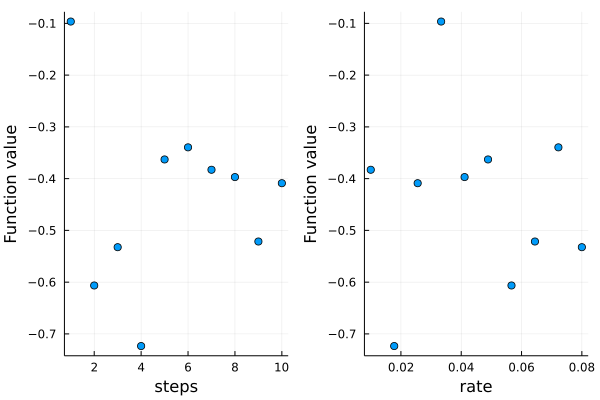

In [30]:
using Plots
plot(hob)

# Flux.jl
First we need to iterate through data load it into Hdf5 and collect the sizes - sizes will be needed as neural network expect uniform sizes of all training and test cases so we will need to get biggest image and pad others accordingly
code is based on https://github.com/Dale-Black/MedicalTutorials.jl/tree/master/src/3D_Segmentation/Heart

In [2]:

# 3D layer utilities from https://github.com/Dale-Black/MedicalTutorials.jl/tree/master/src/3D_Segmentation/Heart
conv = (stride, in, out) -> Flux.Conv((3, 3, 3), in=>out, stride=stride, pad=Flux.SamePad())
tran = (stride, in, out) -> Flux.ConvTranspose((3, 3, 3), in=>out, stride=stride, pad=Flux.SamePad())

conv1 = (in, out) -> Flux.Chain(conv(1, in, out), Flux.BatchNorm(out), x -> leakyrelu.(x))
conv2 = (in, out) -> Flux.Chain(conv(2, in, out), Flux.BatchNorm(out), x -> leakyrelu.(x))
tran2 = (in, out) -> Flux.Chain(tran(2, in, out), Flux.BatchNorm(out), x -> leakyrelu.(x))



function unet3D(in_chs, lbl_chs)
    # Contracting layers
    l1 = Flux.Chain(conv1(in_chs, 4))
    l2 = Flux.Chain(l1, conv1(4, 4), conv2(4, 16))
    l3 = Flux.Chain(l2, conv1(16, 16), conv2(16, 32))
    l4 = Flux.Chain(l3, conv1(32, 32), conv2(32, 64))
    l5 = Flux.Chain(l4, conv1(64, 64), conv2(64, 128))

    # Expanding layers
    l6 = Flux.Chain(l5, tran2(128, 64), conv1(64, 64))
    l7 = Flux.Chain(Flux.Parallel(+, l6, l4), tran2(64, 32), conv1(32, 32))
    l8 = Flux.Chain(Flux.Parallel(+, l7, l3), tran2(32, 16), conv1(16, 16))
    l9 = Flux.Chain(Flux.Parallel(+, l8, l2), tran2(16, 4), conv1(4, 4))
    l10 = Flux.Chain(l9, conv1(4, lbl_chs))
end


unet3D (generic function with 1 method)

In [5]:
model = unet3D(1, 2)
ps = Flux.params(model)  
opt = ADAM() 
loss = Flux.Losses.dice_coeff_loss
device = gpu

gpu (generic function with 1 method)

In [4]:
#close(fid)
pathToHDF55="/media/jakub/NewVolume/projects/bigDataSet.hdf5"
fid = h5open(pathToHDF55, "r+")
# for groupKey in keys(fid)
#     print( size(getGroupOrCreate(fid, groupKey)["image"][:,:,:])) end #(334, 334, 348)

🗂️ HDF5.File: (read-write) /media/jakub/NewVolume/projects/bigDataSet.hdf5
├─ 📂 1
│  ├─ 🏷️ spacing
│  ├─ 🔢 image
│  │  ├─ 🏷️ dataType
│  │  ├─ 🏷️ max
│  │  └─ 🏷️ min
│  └─ 🔢 labelSet
│     ├─ 🏷️ dataType
│     ├─ 🏷️ max
│     └─ 🏷️ min
├─ 📂 10
│  ├─ 🏷️ spacing
│  ├─ 🔢 image
│  │  ├─ 🏷️ dataType
│  │  ├─ 🏷️ max
│  │  └─ 🏷️ min
│  └─ 🔢 labelSet
│     ├─ 🏷️ dataType
│     ├─ 🏷️ max
│     └─ 🏷️ min
├─ 📂 11
│  ├─ 🏷️ spacing
│  ├─ 🔢 image
│  │  ├─ 🏷️ dataType
│  │  ├─ 🏷️ max
│  │  └─ 🏷️ min
│  └─ 🔢 labelSet
│     ├─ 🏷️ dataType
│     ├─ 🏷️ max
│     └─ 🏷️ min
├─ 📂 12
│  ├─ 🏷️ spacing
│  ├─ 🔢 image
│  │  ├─ 🏷️ dataType
│  │  ├─ 🏷️ max
│  │  └─ 🏷️ min
│  └─ 🔢 labelSet
│     ├─ 🏷️ dataType
│     ├─ 🏷️ max
│     └─ 🏷️ min
├─ 📂 13
│  ├─ 🏷️ spacing
│  ├─ 🔢 image
│  │  ├─ 🏷️ dataType
│  │  ├─ 🏷️ max
│  │  └─ 🏷️ min
│  └─ 🔢 labelSet
│     ├─ 🏷️ dataType
│     ├─ 🏷️ max
│     └─ 🏷️ min
├─ 📂 14
│  ├─ 🏷️ spacing
│  ├─ 🔢 image
│  │  ├─ 🏷️ dataType
│  │  ├─ 🏷️ max
│  │  └─ 🏷️ min
│  └─ 🔢 labelSet
│     ├

In [6]:
#taken from https://github.com/FluxML/model-zoo/blob/master/vision/conv_mnist/conv_mnist.jl
maxEpoch=2
for epoch in 1:maxEpoch
    @showprogress for groupKey in keys(fid)
        gr= getGroupOrCreate(fid, groupKey)    
        x=reshape( gr["image"][:,:,:],(334, 334, 348 ,1,1))
        y=reshape( gr["labelSet"][:,:,:],(334, 334, 348 ,1,1))
        x, y = x |> device, y |> device
        gs = Flux.gradient(ps) do
                ŷ = model(x)
                l=loss(ŷ, y)
                print(l)
                l
            end

        Flux.Optimise.update!(opt, ps, gs)
    end
end
    


In [ ]:
modelpath = joinpath(args.savepath, "model.bson")
let model = cpu(model) ## return model to cpu before serialization
    BSON.@save modelpath model 1
end